# SVD & PCA to reconstruct the images

The progress is supposed to be:
- Load the images into numpy arraies
- Apply the SVD & PCA algorithm
- Compare the reconstruction error
- Explore better approaches

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

import warnings

# Disable DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Macros and constants

In [4]:
TIF_TYPE = ["agricultural", "airplane", "beach"]
TIF_PATH = "../Images/"

TIF_AMOUNT = 100

In [5]:
import time

def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} executed {end - start} seconds")
        return result
    return wrapper

## Checkpoint 0
Apply numpy builtin SVD and PCA to reconstruct a sample image

In [6]:
# A sample to load the .tif image
sampleImage = imageio.imread(f"{TIF_PATH}{TIF_TYPE[1]}/{TIF_TYPE[1]}00.tif")
# sampleImage = imageio.imread("loopy.png")
# sampleImage = imageio.imread("pomeranian.jpeg")

print("Sample Image:")
print(f"Shape: {sampleImage.shape}")
print(sampleImage[0][0])


Sample Image:
Shape: (256, 256, 3)
[212 214 213]


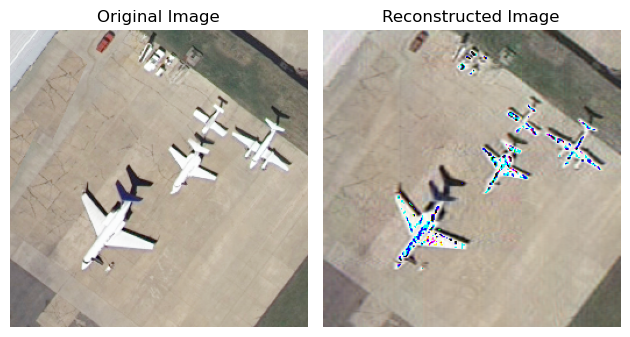

Mean Squared Error (MSE): 65.0579848603663


In [7]:
def sample_svd_only(sampleImage, num_components):
    # Convert the image matrix to a 2D matrix
    image_2d = sampleImage.reshape(sampleImage.shape[0]*sampleImage.shape[2], sampleImage.shape[1])

    # Perform SVD
    U, s, Vt = np.linalg.svd(image_2d, full_matrices=False)

    # Perform PCA by selecting the significant singular vectors
    selected_vectors = U[:, :num_components]

    # Reconstruct the image
    reconstructed_image_2d = np.dot(selected_vectors, np.diag(s[:num_components])).dot(Vt[:num_components, :])
    reconstructed_image = reconstructed_image_2d.reshape(sampleImage.shape)

    # Display the original and reconstructed images
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sampleImage)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image.astype(np.uint8))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    mse = np.mean((image_2d - reconstructed_image_2d)**2)

    print("Mean Squared Error (MSE):", mse)

sample_svd_only(sampleImage, 30)

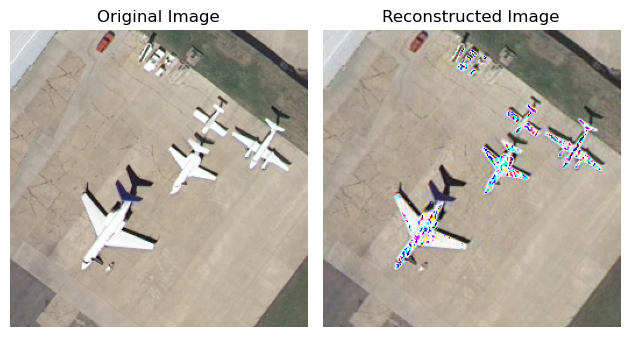

Mean Squared Error (MSE): 29.06321428820543
Compression rate:  0.7393290201822917


In [8]:
def sample_textbook_pca(sampleImage, num_components):
    # Convert the image matrix to a 2D matrix
    image_2d = sampleImage.reshape(sampleImage.shape[0]*sampleImage.shape[2], sampleImage.shape[1])

    # Step 1: Calculate the decentralized matrix Y
    mean_vector = np.mean(image_2d, axis=0)
    decentralized_matrix = image_2d - mean_vector

    # Step 2: Calculate the covariance matrix C
    covariance_matrix = np.cov(decentralized_matrix.T)

    # Step 3: Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Step 4: Select the significant eigenvectors and eigenvalues
    selected_eigenvectors = sorted_eigenvectors[:, :num_components]
    selected_eigenvalues = sorted_eigenvalues[:num_components]

    # Step 5: Reconstruct the vector for each principal component
    reconstructed_vectors = np.dot(decentralized_matrix, selected_eigenvectors)

    # Step 6: Reconstruct the matrix
    reconstructed_image_2d = np.dot(reconstructed_vectors, selected_eigenvectors.T) + mean_vector
    reconstructed_image = reconstructed_image_2d.reshape(sampleImage.shape)

    # Display the original and reconstructed images
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sampleImage)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image.astype(np.uint8))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    mse = np.mean((image_2d - reconstructed_image_2d)**2)

    print("Mean Squared Error (MSE):", mse)
    # print(reconstructed_vectors.size)
    # print(selected_eigenvectors.size)
    # print(selected_eigenvalues.size)
    # print(sampleImage.size)

    component_sizes = selected_eigenvectors.size + selected_eigenvalues.size + reconstructed_vectors.size
    
    # Calculate the compression rate
    compression_rate = component_sizes / sampleImage.size
    print("Compression rate: ", 1 - compression_rate)


sample_textbook_pca(sampleImage, 50)

## Checkpoint 1
Construct a basic function to calculate the eigen value and eigen vector.
The numpy.linalg.eigen will be replaced by this function
(This is the basic requirement of lab2)

In [176]:
class BasicPCAEngine:
    def __init__(self, img_path):
        self.img_path = img_path
    
    # @timeit
    def load_img(self):
        self.image = imageio.imread(self.img_path)

    def basic_eigen(self, mat, num_iterations=1000, tol=1e-6):
        # Initialize a random vector
        v = np.random.rand(mat.shape[0])

        for _ in range(num_iterations):
            # Perform matrix-vector multiplication
            v_new = np.dot(mat, v)

            # Normalize the vector
            v_new /= np.linalg.norm(v_new)

            # Calculate the eigenvalue estimate
            eigenvalue = np.dot(v_new.T, np.dot(mat, v_new))

            # Check for convergence
            if np.abs(eigenvalue - np.dot(v.T, np.dot(mat, v))) < tol:
                break

            # Update the vector
            v = v_new

        # Calculate the eigenvector
        eigenvector = v

        return eigenvalue, eigenvector

    @timeit
    def pca(self):
        # Convert the image matrix to a 2D matrix
        self.image_2d = self.image.reshape(self.image.shape[0]*self.image.shape[2], self.image.shape[1])

        # Step 1: Calculate the decentralized matrix Y
        self.mean_vector = np.mean(self.image_2d, axis=0)
        self.decentralized_matrix = self.image_2d - self.mean_vector

        # Step 2: Calculate the covariance matrix C
        covariance_matrix = np.cov(self.decentralized_matrix.T)

        # Step 3: Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues = []
        eigenvectors = []

        for i in range(covariance_matrix.shape[0]):
            eigenvalue, eigenvector = self.basic_eigen(covariance_matrix)
            # eigenvalue, eigenvector = np.linalg.eig(covariance_matrix)
            eigenvalues.append(eigenvalue)
            eigenvectors.append(eigenvector)

            # Deflate the covariance matrix
            covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)

        # eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        eigenvalues = np.array(eigenvalues)
        eigenvectors = np.array(eigenvectors)

        self.eigenvalues = eigenvalues
        # self.eigenvectors = eigenvectors
        self.eigenvectors = eigenvectors.T
    

    @timeit
    def reconstruct(self, num_components):
        # Step 4: Select the significant eigenvectors and eigenvalues
        self.selected_eigenvectors = self.eigenvectors[:, :num_components]
        self.selected_eigenvalues = self.eigenvalues[:num_components]

        # Step 5: Reconstruct the vector for each principal component
        self.reconstructed_vectors = np.dot(self.decentralized_matrix, self.selected_eigenvectors)

        # Step 6: Reconstruct the matrix
        self.reconstructed_image_2d = np.dot(self.reconstructed_vectors, self.selected_eigenvectors.T) + self.mean_vector
        self.reconstructed_image = self.reconstructed_image_2d.reshape(self.image.shape)
    
    # Tools and helper functions:
    def show_img(self):
        # Display the original and reconstructed images
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(self.image)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(self.reconstructed_image.astype(np.uint8))
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    def reconstruct_err(self):
        return np.linalg.norm((self.image_2d - self.reconstructed_image_2d)**2)

    def compress_rate(self):
        component_sizes = self.selected_eigenvectors.size + self.selected_eigenvalues.size + self.reconstructed_vectors.size
    
        # Calculate the compression rate
        rate = component_sizes / self.image.size
        return 1 - rate

- In this case, I use basic power method to calculate all the eigen values, which is very costly in time

load_img executed 0.0013933181762695312 seconds
pca executed 3.4248619079589844 seconds
reconstruct executed 0.0017478466033935547 seconds


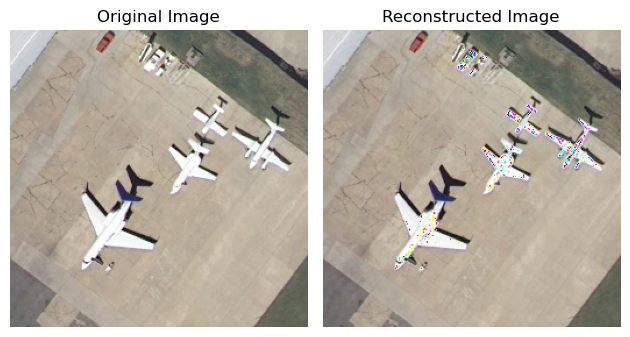

12871.70203473341
0.47865804036458337


In [142]:
testEngine = BasicPCAEngine(f"{TIF_PATH}{TIF_TYPE[1]}/{TIF_TYPE[1]}00.tif")

testEngine.load_img()
testEngine.pca()
testEngine.reconstruct(100)
testEngine.show_img()

print(testEngine.reconstruct_err())
print(testEngine.compress_rate())

## Checkpoint 2
Improvement: As we can see from the result above, the basic method includes two flaws:
- Calculating eigenvalues and eigenvector is costly
- Look at the plane!!! Why there is lots of red, blue, and yellow dots on the white paintings!!!

So the eigen() function and reconstuct() method should be improved.

In [178]:
class R_pca:
    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        # print("RPCA Iter: ", iter)
        return Lk, Sk

class RPCAEngine:
    def __init__(self, img_path):
        self.img_path = img_path
    
    def load_img(self):
        self.image = imageio.imread(self.img_path)
        self.image_shape = self.image.shape
    
    def preprocess(self):
        # Convert the image to a 2D matrix
        self.image_2d = self.image.reshape(self.image.shape[0]*self.image.shape[2], self.image.shape[1])
        # print(self.image_2d.shape)
        
        # Subtract the mean vector from the image matrix
        self.mean_vector = np.mean(self.image_2d, axis=0)
        self.image_centered = self.image_2d - self.mean_vector
    
    @timeit
    def reconstruct(self, num_iter = 100):
        rpca = R_pca(self.image_centered)
        L, S = rpca.fit(max_iter=num_iter, iter_print=10)
        self.reconstructed_image = L + self.mean_vector + S
        # self.reconstructed_image = L + np.reshape(self.mean_vector, (-1, 1)) + S

        self.reconstructed_image = self.reconstructed_image.reshape(self.image.shape)
        self.L = L.reshape(self.image.shape)
        self.S = S.reshape(self.image.shape)
    
    # Tools and helper functions:
    def show_img(self):
        # Display the original and reconstructed images
        plt.subplot(2, 2, 1)
        plt.title("Original Image")
        plt.imshow(self.image)
        plt.axis("off")

        plt.subplot(2, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(self.reconstructed_image.astype(np.uint8))
        plt.axis("off")

        plt.subplot(2, 2, 3)
        plt.title("Low Rank")
        plt.imshow(self.L.astype(np.uint8))
        plt.axis("off")

        plt.subplot(2, 2, 4)
        plt.title("Sparse")
        plt.imshow(self.S.astype(np.uint8))
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    def reconstruct_err(self):
        return np.linalg.norm((self.image - self.reconstructed_image)**2)

    def compress_rate(self):
        return 1 - np.linalg.matrix_rank(self.L)[0] / self.image.shape[0]
    
    def l_rank(self):
        return np.linalg.matrix_rank(self.L)[0]


(768, 256)
preprocess executed 0.0008981227874755859 seconds
iteration: 1, error: 5.174944550402167
iteration: 10, error: 0.011058254007374533
iteration: 20, error: 0.011501580337137952
iteration: 30, error: 0.011923716986219727
iteration: 40, error: 0.012384004590802293
iteration: 50, error: 0.012859111860926762
RPCA Iter:  50
reconstruct executed 3.244558095932007 seconds


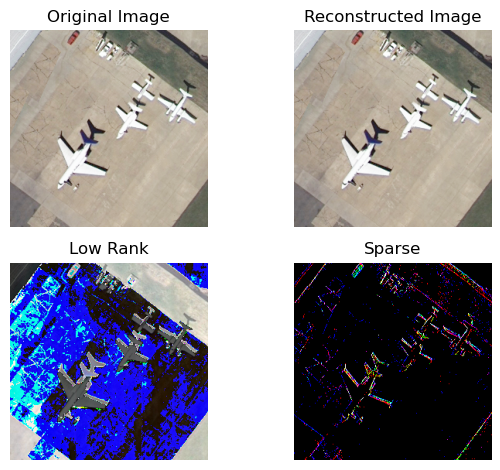

1.153317020970679e-06
3


In [162]:
testEngine = RPCAEngine(f"{TIF_PATH}{TIF_TYPE[1]}/{TIF_TYPE[1]}00.tif")
# testEngine = RPCAEngine(f"loopy.png")
testEngine.load_img()
testEngine.preprocess()
testEngine.reconstruct(50)
testEngine.show_img()

print(testEngine.reconstruct_err())
print(testEngine.l_rank())

## Checkpoint 3

Great! We have achieved great result after implemented rpca. Now we can conduct some benchmarking

According to the assignment, three benchmarks are going to be tested:
- Compression rate
- Compression time
- Reconstruct Error

In [193]:
import time

### Some benchmarking marcos ###

def single_test(img_type, img_index, pca_type = 0, iteration=50, components = 50):
    """
    Paramters:
    ---
    img_type, img_index: refer to the TIF marcos, index range from [0, 99], type range from [0, 2]
    pca_type: 0: basic pca, 1: robust pca
    iteration: RPCA only, define the iteration time
    components: Basic PCA only, define the reconstuction components

    Returns:
    ---
    A Three element list: [Reconstuction time, Reconstuction Error, Compression rate]
    """

    # format the target tif file
    temp_zero = "0" if img_index < 10 else ""
    path = f"{TIF_PATH}{TIF_TYPE[1]}/{TIF_TYPE[1]}{temp_zero}{img_index}.tif"
    ret = []
    if pca_type == 0:
        eng = BasicPCAEngine(path)
        eng.load_img()

        start_time = time.time()
        eng.pca()
        eng.reconstruct(components)
        end_time = time.time()

        ret.append(end_time - start_time)
        ret.append(eng.reconstruct_err())
        ret.append(eng.compress_rate())

    elif pca_type == 1:
        eng = RPCAEngine(path)
        eng.load_img()

        start_time = time.time()
        eng.preprocess()
        eng.reconstruct(iteration)
        end_time = time.time()

        ret.append(end_time - start_time)
        ret.append(eng.reconstruct_err())
        ret.append(eng.compress_rate())
    
    return ret


def bpca_benchmark(types):
    components_range = range(1, 51, 5)
    num_tests = len(components_range)
    benchmarks = np.zeros((3, num_tests))

    for i, components in enumerate(components_range):
        print(f"Running Basic PCA Engine with components: {components}")
        total_time = 0
        total_error = 0
        total_rate = 0

        for img_index in range(100):
            results = single_test(types, img_index, pca_type=0, components=components)
            total_time += results[0]
            total_error += results[1]
            total_rate += results[2]
            print(f"Running on image set {types}, index {img_index}, components {components}")

        avg_time = total_time / 100
        avg_error = total_error / 100
        avg_rate = total_rate / 100

        benchmarks[0, i] = avg_time
        benchmarks[1, i] = avg_error
        benchmarks[2, i] = avg_rate

    print(benchmarks)
    # Plot the benchmarks
    plt.figure(figsize=(16, 4))
    iterations = list(components_range)

    plt.subplot(1, 3, 1)
    plt.plot(iterations, benchmarks[0], marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Time')
    plt.title('BPCA: Reconstruction Time')

    plt.xticks(range(1, 51, 5))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(iterations, benchmarks[1], marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('BPCA: Reconstruction Error')

    plt.xticks(range(1, 51, 5))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(iterations, benchmarks[2], marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Compression Rate')
    plt.title('BPCA: Compression Rate')

    plt.ylim(0.0, 1.0)
    plt.xticks(range(1, 51, 5))
    plt.grid()

    plt.tight_layout()
    plt.show()


# Perform benchmarking for RPCA Engine
def rpca_benchmark(types):
    iterations_range = range(1, 21, 2)
    num_tests = len(iterations_range)
    benchmarks = np.zeros((3, num_tests))

    for i, iterations in enumerate(iterations_range):
        print(f"Running RPCA Engine with iterations: {iterations}")
        total_time = 0
        total_error = 0
        total_rate = 0

        for img_index in range(100):
            results = single_test(types, img_index, pca_type=1, iteration=iterations)
            total_time += results[0]
            total_error += results[1]
            total_rate += results[2]
            print(f"Running on image set {types}, index {img_index}")

        avg_time = total_time / 100
        avg_error = total_error / 100
        avg_rate = total_rate / 100

        benchmarks[0, i] = avg_time
        benchmarks[1, i] = avg_error
        benchmarks[2, i] = avg_rate

    print(benchmarks)
    # Plot the benchmarks
    plt.figure(figsize=(16, 4))
    iterations = list(iterations_range)

    plt.subplot(1, 3, 1)
    plt.plot(iterations, benchmarks[0], marker='o')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Reconstruction Time')
    plt.title('RPCA: Reconstruction Time vs Number of Iterations')

    plt.xticks(range(1, 21, 2))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(iterations, benchmarks[1], marker='o')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Reconstruction Error')
    plt.title('RPCA: Reconstruction Error vs Number of Iterations')

    plt.xticks(range(1, 21, 2))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(iterations, benchmarks[2], marker='o')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Compression Rate')
    plt.title('RPCA: Compression Rate vs Number of Iterations')

    plt.ylim(0.0, 1.0)
    plt.xticks(range(1, 21, 2))
    plt.grid()

    plt.tight_layout()
    plt.show()

Running Basic PCA Engine with components: 1
pca executed 4.438407897949219 seconds
reconstruct executed 0.0017349720001220703 seconds
Running on image set 2, index 0, components 1
pca executed 2.5889389514923096 seconds
reconstruct executed 0.0008289813995361328 seconds
Running on image set 2, index 1, components 1
pca executed 2.2873311042785645 seconds
reconstruct executed 0.0011827945709228516 seconds
Running on image set 2, index 2, components 1
pca executed 2.3076648712158203 seconds
reconstruct executed 0.0035331249237060547 seconds
Running on image set 2, index 3, components 1
pca executed 2.228066921234131 seconds
reconstruct executed 0.001049041748046875 seconds
Running on image set 2, index 4, components 1
pca executed 2.217634916305542 seconds
reconstruct executed 0.001046895980834961 seconds
Running on image set 2, index 5, components 1
pca executed 2.495999813079834 seconds
reconstruct executed 0.0011467933654785156 seconds
Running on image set 2, index 6, components 1
pca

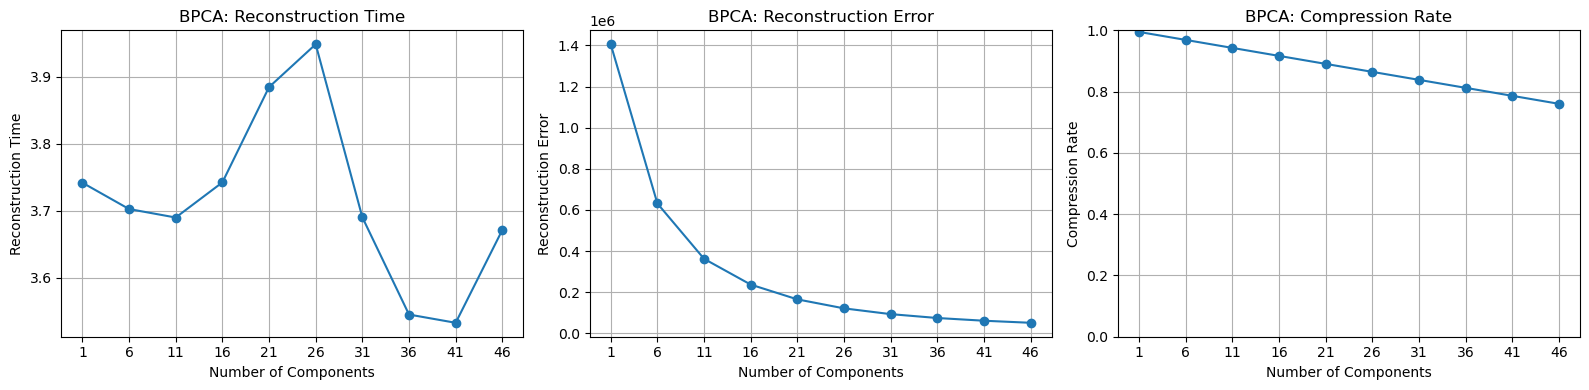

In [196]:
# single_test(1, 20, 1, iteration=1)
bpca_benchmark(2)